In [1]:
from datetime import datetime
from typing import Tuple, List, Union, Dict, Any
import json
import sys
import os
import uuid
import random

# Include subpath as module path
module_path = os.path.abspath(os.path.join(".."))
if module_path not in sys.path:
    sys.path.append(module_path)

print("Module path: ", module_path)

from stream_handler import setup
setup()

import backend.disorientationdetectors as detectors

from backend.typealias import CoordinatePair, Sequence, Token, Pattern
import backend.datastructures as ds 
import backend.utils as utils
import backend.detectorevaluator as evaluator
import backend.plotutils as plotutils
import backend.staypointdetector as spdetector
import backend.geohashsequenceinterpolator as ip
import backend.datapointstreamhandler as shandler
import backend.xchanges as xchanges
import backend.trajectorysegmentor as segmentor 
import backend.dataframeinterfaces as dfinterfaces
from django.conf import settings

import backend.models as django_models
import backend.managers as django_managers
from shapely.geometry import Polygon, Point

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.lines import Line2D
from matplotlib.dates import DateFormatter

import pandas as pd
import numpy as np
import seaborn as sns
import msgpack

# Set the following flag such that we are able to run Django inside a jupyter notebook:
os.environ["DJANGO_ALLOW_ASYNC_UNSAFE"] = "true"

# Settings
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

bits_per_char = 2
center = [55.3923666589426, 10.386784608945067]
user = "d1b0c137-1cd0-4430-ad88-4dc24c88f3ad"

Module path:  /home/nicklasxyz/Desktop/traj-dirs/rtdm/RealtimeTrajectoryDataMining/rtdm


In [3]:
df_batch = evaluator.read_all("data/case_study_3.json")

In [28]:

dd1_params = {
    "precision": 18,
    "threshold_low": 0,
    "threshold_high": 0.4,
    "window_size": "1000T",
    "max_merging_distance": 28,
    "min_frequency": 1,
    "sequence_interpolator": ip.NaiveGeohashSequenceInterpolator,
}

de = evaluator.LeaveOneOutDetectorEvaluator(
    data_in={0: df_batch[0]},
    user=user,
    method="dd1",
    params=dd1_params,
)
df_out = de.evaluate_detector()

INFO: Call to <function ScoringDataFrame.handle at 0x7f28e459be50>. Elapsed time (sysusr): 0.18810970999999999 Elapsed time (wall): 0.19432306289672852
INFO: Call to <function ScoringDataFrame.handle at 0x7f28e459be50>. Elapsed time (sysusr): 0.21558098299999995 Elapsed time (wall): 0.22585272789001465
INFO: Call to <function ScoringDataFrame.handle at 0x7f28e459be50>. Elapsed time (sysusr): 0.19156416499999995 Elapsed time (wall): 0.2067403793334961
INFO: Call to <function ScoringDataFrame.handle at 0x7f28e459be50>. Elapsed time (sysusr): 0.21225888700000017 Elapsed time (wall): 0.2133960723876953INFO: Call to <function ScoringDataFrame.handle at 0x7f28e459be50>. Elapsed time (sysusr): 0.1766157380000002 Elapsed time (wall): 0.19646430015563965

INFO: Call to <function ScoringDataFrame.handle at 0x7f28e459be50>. Elapsed time (sysusr): 0.2798350810000001 Elapsed time (wall): 0.2978355884552002
INFO: Call to <function ScoringDataFrame.handle at 0x7f28e459be50>. Elapsed time (sysusr): 0.

In [21]:
cp = sns.color_palette("tab10")
cp_list = list(cp.as_hex())

_dfs = df_out[0]["df"]
_anom_dfs = _dfs[(_dfs["anomalous"] == True) & (_dfs["outcome"] == True)]
df_ = _anom_dfs.iloc[-1]["detect_df"]
df_

,sequence,similarity_score,anomaly_score,anomaly,latitude,longitude,uid
2021-08-15 03:46:55.328,[210012231012212313],1.000000,0.000000,False,55.375106,10.396267,2a2202df-45fc-4697-953c-f80d6d06f610
2021-08-15 03:47:52.922,"[210012231012212313, 210012231012212320]",1.000000,0.000000,False,55.375469,10.396287,2a2202df-45fc-4697-953c-f80d6d06f610
2021-08-15 03:49:09.537,"[210012231012212313, 210012231012212320, 21001...",1.000000,0.000000,False,55.376254,10.396480,2a2202df-45fc-4697-953c-f80d6d06f610
2021-08-15 03:49:56.831,"[210012231012212313, 210012231012212320, 21001...",1.000000,0.000000,False,55.376706,10.396461,2a2202df-45fc-4697-953c-f80d6d06f610
2021-08-15 03:51:27.271,"[210012231012212313, 210012231012212320, 21001...",1.000000,0.000000,False,55.377684,10.396689,2a2202df-45fc-4697-953c-f80d6d06f610
...,...,...,...,...,...,...,...
2021-08-15 04:47:35.693,"[210012231012212313, 210012231012212320, 21001...",0.338983,0.678571,True,55.392460,10.390012,2a2202df-45fc-4697-953c-f80d6d06f610
2021-08-15 04:48:20.760,"[210012231012212313, 210012231012212320, 21001...",0.350000,0.678571,True,55.392646,10.390569,2a2202df-45fc-4697-953c-f80d6d06f610
2021-08-15 04:49:10.798,"[210012231012212313, 210012231012212320, 21001...",0.360656,0.678571,True,55.393081,10.390949,2a2202df-45fc-4697-953c-f80d6d06f610
2021-08-15 04:51:15.143,"[210012231012212313, 210012231012212320, 21001...",0.370968,0.678571,True,55.394067,10.391821,2a2202df-45fc-4697-953c-f80d6d06f610


In [22]:
sns.set_theme(style = "whitegrid")
sns.set_context("paper", font_scale = 1.75,  rc = {"lines.linewidth": 1.75})

In [23]:
anom_coords = df_[df_["anomaly"] == True][["latitude", "longitude"]].values[0]
anom_coords

array([55.3856562 , 10.37651512])

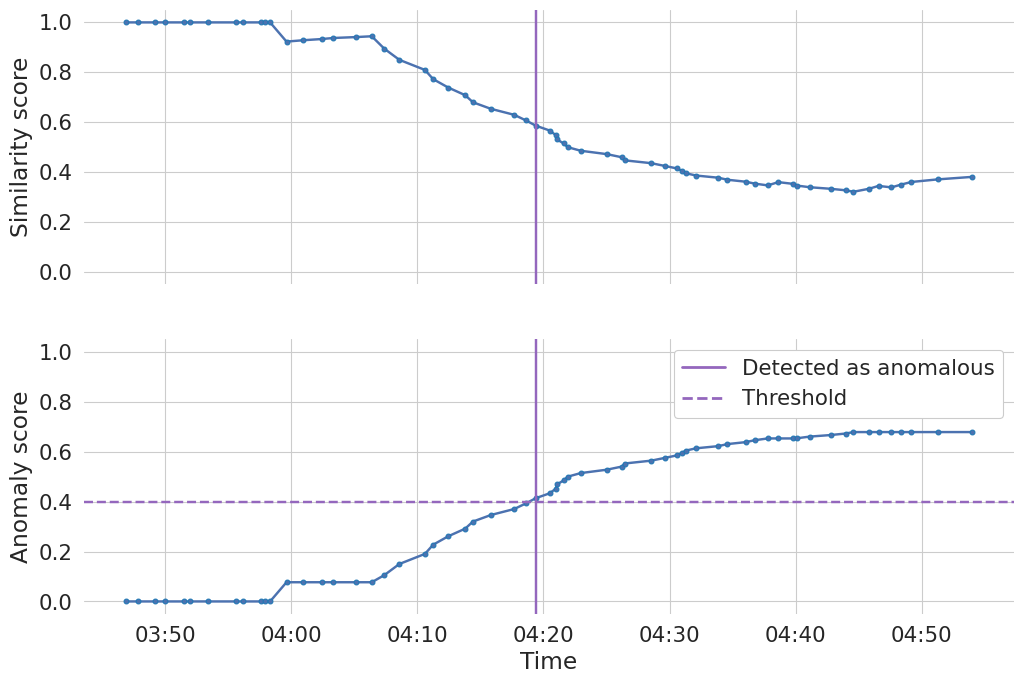

In [24]:
# temp_df_anom = this_df[this_df["uid"] == uid]["detect_df"].iloc[0]
# df_ = temp_df_anom
# df_

fig, axs = plt.subplots(2, 1, sharex = True, sharey = True)

sns.lineplot(
    x = df_.index.values,
    y = df_["similarity_score"].values,
    dashes = False,
    ax = axs[0],
    **{"marker": "o", "markersize": 3.5, "markeredgecolor": cp_list[0]}
)
sns.lineplot(
    x = df_.index.values,
    y = df_["anomaly_score"].values,
    dashes = False,
    ax = axs[1],
    **{"marker": "o", "markersize": 3.5, "markeredgecolor": cp_list[0]}
)

axs[0].set_ylabel("Similarity score")
axs[1].set_ylabel("Anomaly score")
axs[1].set_xlabel("Time")

axs[0].axvline(df_[df_["anomaly"] == True].index.values[0], **{"color": cp_list[4]})
axs[1].axvline(df_[df_["anomaly"] == True].index.values[0], **{"color": cp_list[4]})
axs[1].axhline(dd1_params["threshold_high"], **{"color": cp_list[4], "linestyle": "--"})

custom = [
    Line2D([0], [0], lw = 2, color=cp_list[4], linestyle="-"),
    Line2D([0], [0], lw = 2, color=cp_list[4], linestyle="--"),     
]

plt.legend(
    custom, [
        "Detected as anomalous",
        "Threshold"
    ], loc  = "upper right",
    markerscale = 2,
    framealpha = 1.,
)

axs[1].xaxis.set_major_formatter(DateFormatter('%H:%M'))

sns.despine(fig, left = True, bottom  = True, right = True, top = True)

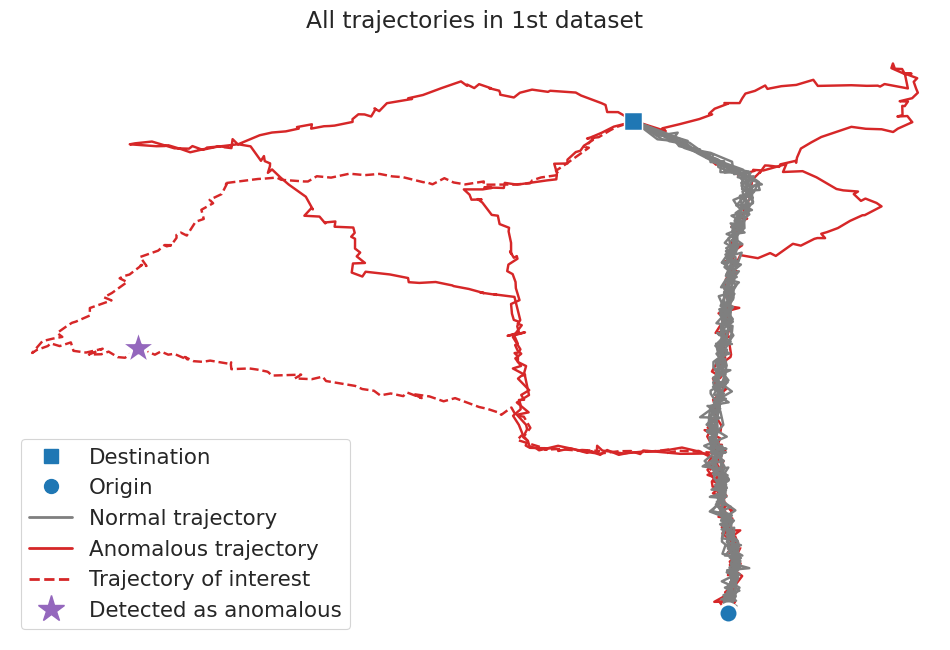

In [27]:
dfs = _dfs["df"]

fig, axs = plt.subplots(1, sharex = True, sharey = True)
xss = []
yss = []
for i in range(dfs.shape[0]): 
    xs = dfs.iloc[i]["longitude"].values
    ys = dfs.iloc[i]["latitude"].values
    xss.extend(xs)
    yss.extend(ys)
    
x_max = np.max(xss)
x_min = np.min(xss)
x_margin = (x_max - x_min) * 0.025

y_max = np.max(yss)
y_min = np.min(yss)
y_margin = (y_max - y_min) * 0.05

uid = "2a2202df-45fc-4697-953c-f80d6d06f610"

for i in range(dfs.shape[0]): 
    xs = dfs.iloc[i]["longitude"].values
    ys = dfs.iloc[i]["latitude"].values
    temp_df = dfs.iloc[i]
    if temp_df[temp_df["anom_start"] == True].shape[0] == 0:
        
        sns.lineplot(
            x = xs, y = ys, sort = False, ax = axs,
            **{"color": cp_list[7]}, # Gray
        )
    else:
        if uid == temp_df["uid"].values[0]:
            sns.lineplot(
                x = xs, y = ys, sort = False, ax = axs,
                **{"color": cp_list[3], "linestyle": "--"}, # Red
            )
        else:

            sns.lineplot(
                x = xs, y = ys, sort = False, ax = axs,
                **{"color": cp_list[3]}, # Red
            )

start_x = xs[0]; start_y = ys[0]
end_x = xs[-1]; end_y = ys[-1]

sns.scatterplot(
    x = [start_x], y = [start_y], ax = axs,
    **{"zorder":dfs.shape[0] + 1, "s": 750, "marker": ".", "color": cp_list[0]}
)
sns.scatterplot(
    x = [end_x], y = [end_y], ax = axs,
    **{"zorder":dfs.shape[0] + 2, "s": 175, "marker": "s", "color": cp_list[0]},
)
axs.set_title('All trajectories in 1st dataset')
axs.set_xlim([x_min - x_margin, x_max + x_margin])
axs.set_ylim([y_min - y_margin, y_max + y_margin])


# Anom start
sns.scatterplot(
    x = [anom_coords[1]], y = [anom_coords[0]], ax = axs,
    **{"zorder":dfs.shape[0] + 3, "s": 750, "marker": "*", "color": cp_list[4]},
)


custom = [
    Line2D([], [], marker="s", markersize=5, color=cp_list[0], linestyle="None"), # Color: Blue
    Line2D([], [], marker=".", markersize=10, color=cp_list[0], linestyle="None"), # Color: Blue
    Line2D([0], [0], lw = 2, color=cp_list[7], linestyle="-"), # Color: Gray
    Line2D([0], [0], lw = 2, color=cp_list[3], linestyle="-"), # Color: Red     
    Line2D([0], [0], lw = 2, color=cp_list[3], linestyle="--"), # Color: Red     
    Line2D([], [], marker="*", markersize=10, color=cp_list[4], linestyle="None"),
]

plt.legend(
    custom, [
        "Destination", "Origin",
        "Normal trajectory", "Anomalous trajectory",
        "Trajectory of interest",
        "Detected as anomalous",
    ], loc  = "lower left", markerscale = 2)

axs.axis("off")
fig.patch.set_visible(False)
sns.despine(fig, left = True, bottom  = True, right = True, top = True)